# Problem Statement

Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

* Historical data of demand for a product-center combination (Weeks: 1 to 145)
* Product(Meal) features such as category, sub-category, current price and discount
* Information for fulfillment center like center area, city information etc.

In [1]:
# IMPORTING THE NECESSARY LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
# READING THE DATA IN TRAIN, MEALS, CENTRE, TEST, SUBMISSION VARIABLES

train=pd.read_csv("train.csv")
meals=pd.read_csv("meal_info.csv")
centre=pd.read_csv("fulfilment_center_info.csv")
test=pd.read_csv("test_QoiMO9B.csv")
submission=pd.read_csv("sample_submission_hSlSoT6.csv")

In [3]:
# READING THE SHAPE OF THE DATAS

train.shape,meals.shape,centre.shape,test.shape

((456548, 9), (51, 3), (77, 5), (32573, 8))

In [4]:
# COMBINING THE DATA 

combined=pd.concat([train,test],ignore_index=True)

In [5]:
# COMBINING THE DATA COMBINED AND MEALS USING MEAL ID 

combined=pd.merge(combined,meals,on=["meal_id"],how="left")

In [6]:
# COMBINING THE DATA COMBINED AND CENTRE USING CENTRE ID 

combined=pd.merge(combined,centre,on=["center_id"],how="left")

In [7]:
#SHAPE OF THE ALL COMBINED DATA 

combined.shape

(489121, 15)

In [8]:
# FIRST 5 ROWS OF THE DATASET

combined.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270.0,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189.0,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54.0,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40.0,Beverages,Indian,647,56,TYPE_C,2.0


In [9]:
# COLUMNS PRESENT IN THE COMBINED DATASET

combined.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area'],
      dtype='object')

In [10]:
# CREATING THE VARIABLES FOR THE CATEGORICAL AND NUMERICAL COLUMNS

catcols=["center_id","meal_id","emailer_for_promotion","homepage_featured","category","cuisine","city_code",
         "region_code","center_type"]
numcols=['checkout_price', 'base_price','num_orders',"Difference_in_price","op_area"]

In [11]:
# DIFFERENCE IN CHECKOUT PRICE AND BASE PRICE

combined["Difference_in_price"]=abs(combined.base_price-combined.checkout_price)

### UNIVARIATE ANALYSIS

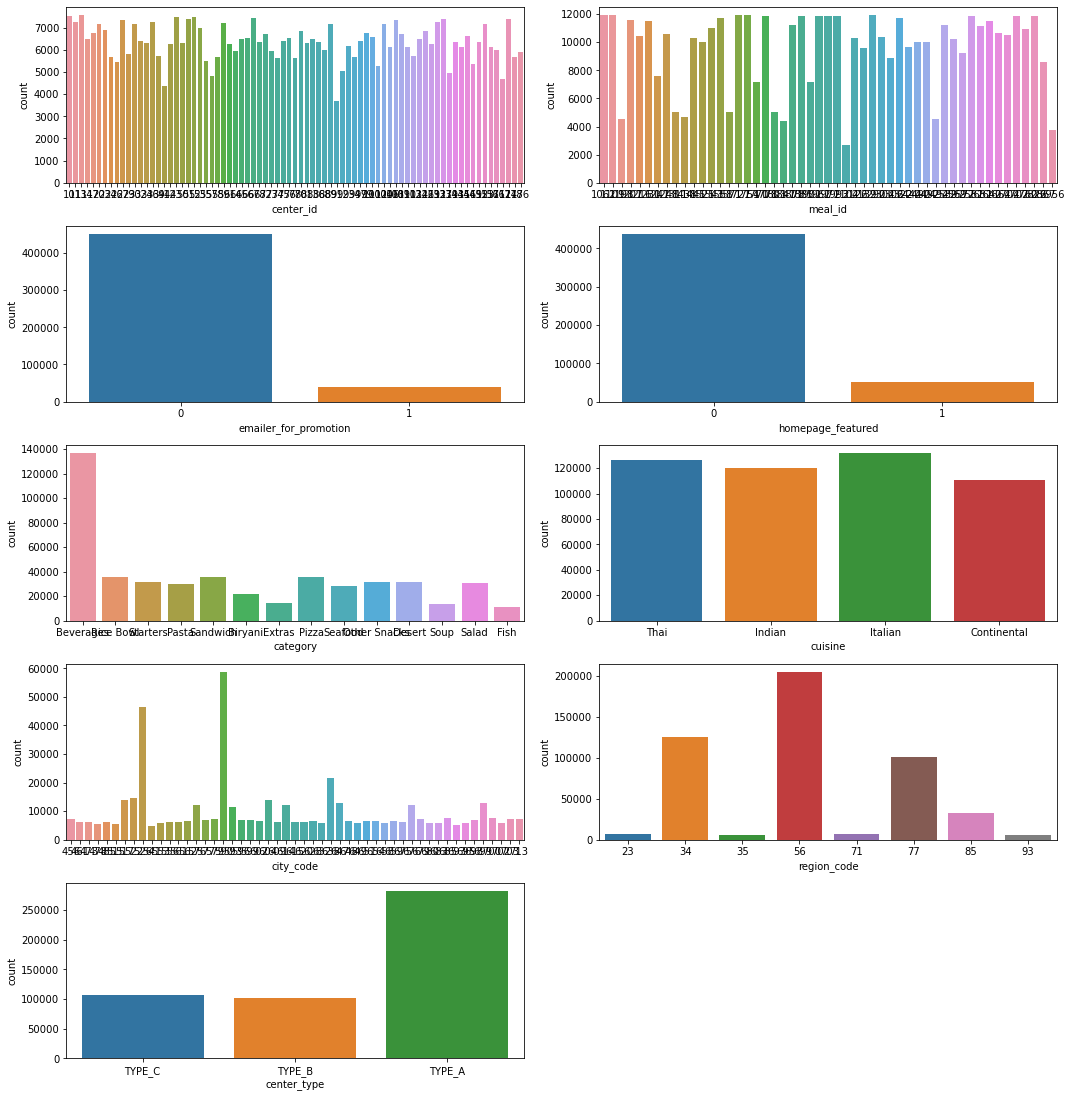

In [12]:
# SHOWING THE COUNT OF THE CATEGORICAL COLUMNS.

iterator=1
plt.figure(figsize=(15,18))
for i in catcols:
    plt.subplot(6,2,iterator)
    sns.countplot(combined[i])
    iterator+=1
plt.tight_layout()
plt.show()

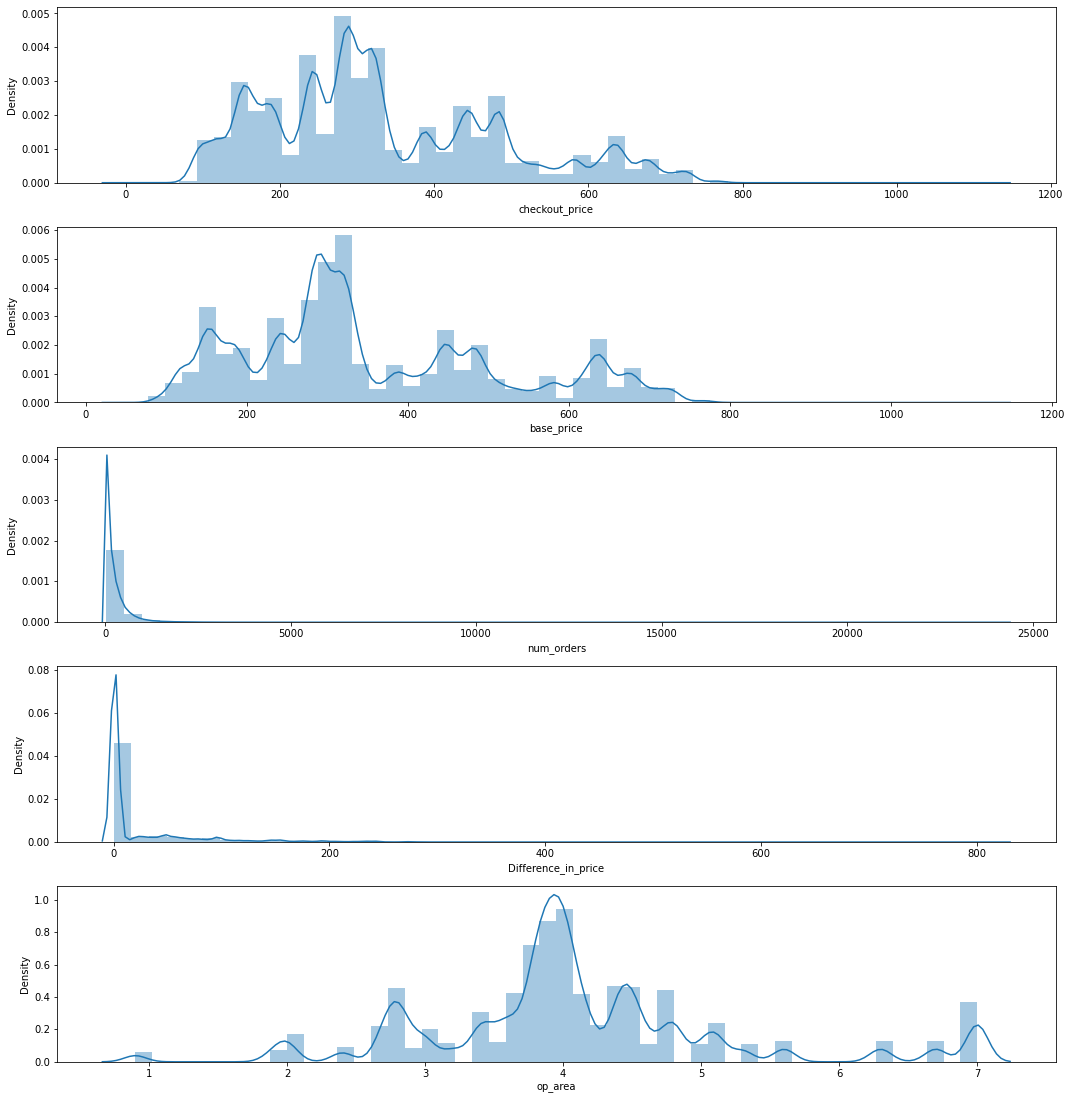

In [58]:
# DISPLAYING THE DISTPLOT FOR THE NUMERICALS COLUMNS

iterator=1
plt.figure(figsize=(15,18))
for i in numcols:
    plt.subplot(6,1,iterator)
    sns.distplot(combined[i])
    iterator+=1
plt.tight_layout()
plt.show()

### BIVARIATE ANALYSIS

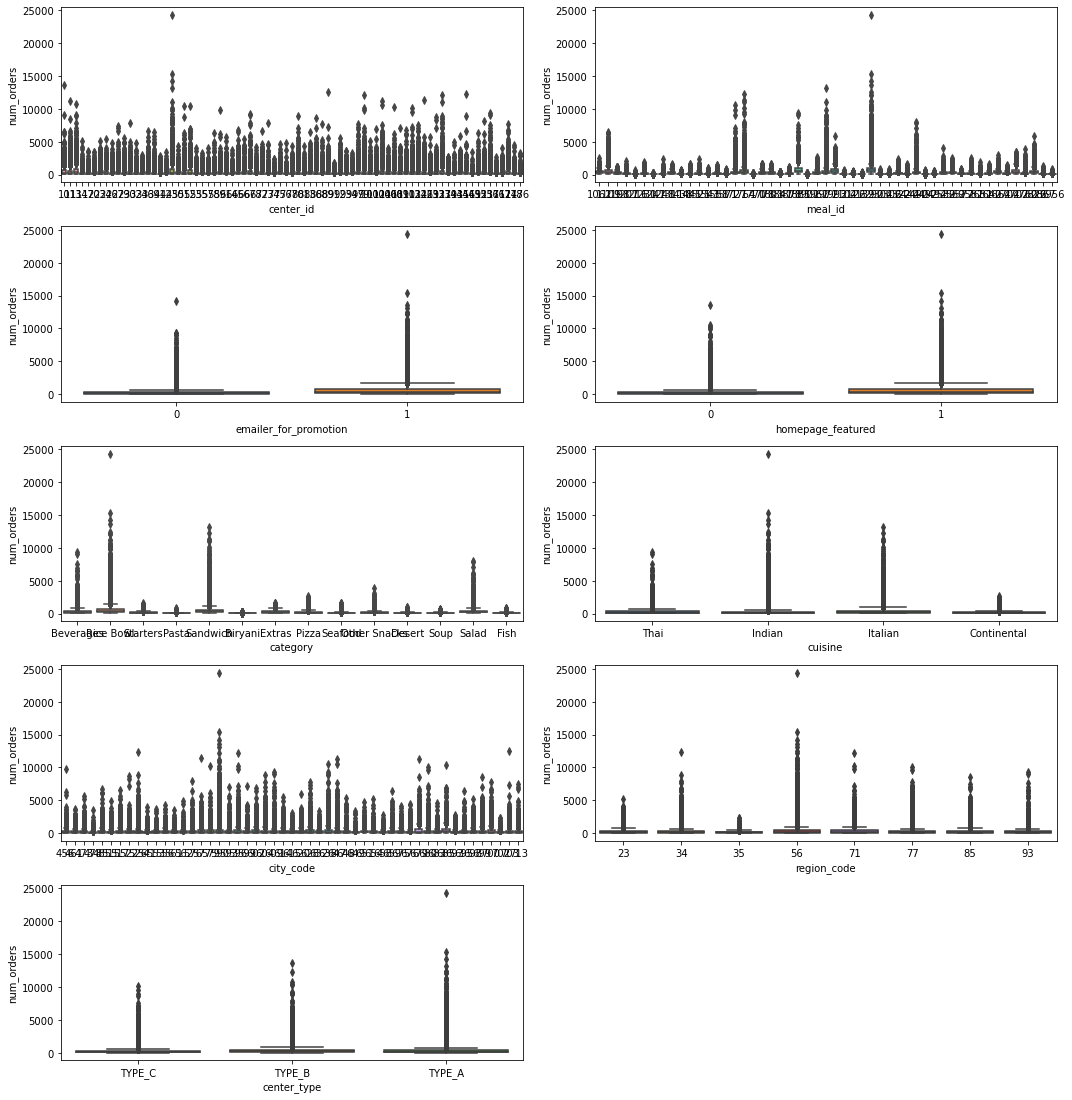

In [14]:
iterator=1
plt.figure(figsize=(15,18))
for i in catcols:
    plt.subplot(6,2,iterator)
    sns.boxplot(combined[i],combined.num_orders)
    iterator+=1
plt.tight_layout()
plt.show()

# most people prefer ricebowl,bevrages,sandwich salad
# most people prefer indian food
# most popular region code is 56
# food procurement is happeing from centre type a

In [15]:
combined["social_media"]=combined.emailer_for_promotion+combined.homepage_featured

# MAKING A NEW COLUMN SOCIAL MEDIA BY ADDING emailer_for_promotion AND homepage_featured

<AxesSubplot:xlabel='social_media', ylabel='num_orders'>

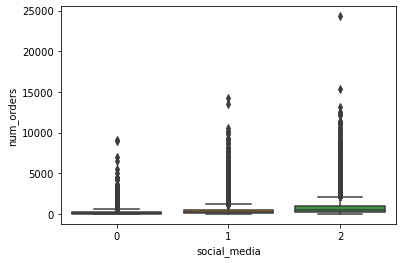

In [16]:
sns.boxplot(combined.social_media,combined.num_orders)

# VISUALIZATION OF THE SOCIAL MEDIA AND THE NUM OF ORDERS

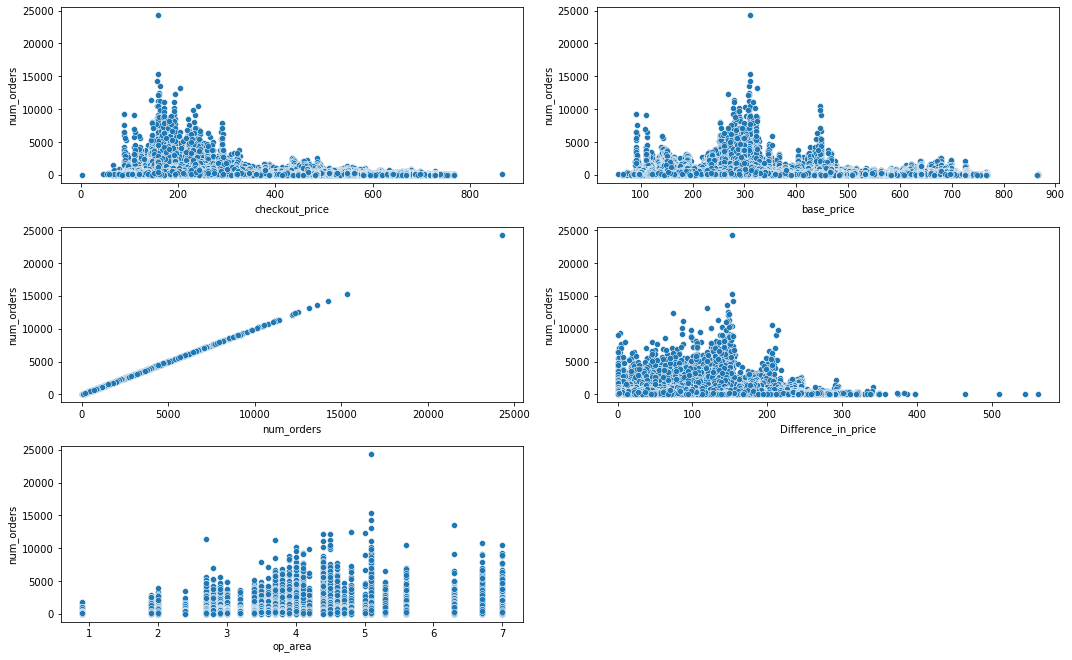

In [17]:
# DISPLAYING THE SCATTER PLOT FOR THE NUMERICAL COLUMNS

iterator=1
plt.figure(figsize=(15,18))
for i in numcols:
    plt.subplot(6,2,iterator)
    sns.scatterplot(combined[i],combined.num_orders)
    iterator+=1
plt.tight_layout()
plt.show()

In [18]:
combined.city_code.unique()

# ALL THE UNIQUE CODE IN THE city_code COLUMN.

array([647, 614, 679, 659, 526, 590, 599, 685, 461, 649, 541, 478, 703,
       576, 628, 702, 579, 596, 648, 632, 522, 615, 577, 517, 651, 683,
       713, 609, 675, 553, 593, 654, 693, 658, 515, 556, 561, 680, 620,
       638, 700, 676, 604, 456, 562, 695, 699, 602, 485, 698, 473],
      dtype=int64)

### FEATURE ENGINEERING

In [19]:
combined["region"]=combined.city_code.astype("str")+"_"+combined.region_code.astype("str")

# MAKING A NEW COLUMN NAME REGION FROM city_code AND region_code

In [20]:
combined["count_city_region"]=combined.groupby(by="region_code")["city_code"].transform("nunique")

# MAKING A NEW COLUMN NAME count_city_region BY GROUPING THE region_code AND TAKING THE UNIQUE CITY CODE.

In [21]:
combined["count_orders_region"]=combined.groupby(by="region_code")["meal_id"].transform("nunique")
combined["avg_orders_region"]=combined.groupby(by="region_code")["meal_id"].transform("mean")
combined["std_orders_region"]=combined.groupby(by="region_code")["meal_id"].transform("std")
combined["median_orders_region"]=combined.groupby(by="region_code")["meal_id"].transform("median")

# TAKING THE MEAN,STD, MEDIAN AND NUNIQUE OF THE COLUMNS AND EXTRACTING INFORMATION FROM EXISTING COLUMNS.

In [22]:
# count of cities basisn centre type

combined["count_of_cities"]=combined.groupby(by="center_type")["city_code"].transform("nunique")

In [23]:
# citywise count of meals
combined["count_orders_city"]=combined.groupby(by="city_code")["meal_id"].transform("nunique")
combined["avg_orders_city"]=combined.groupby(by="city_code")["meal_id"].transform("mean")
combined["std_orders_city"]=combined.groupby(by="city_code")["meal_id"].transform("std")
combined["median_orders_city"]=combined.groupby(by="city_code")["meal_id"].transform("median")

In [24]:
#category wise number of orders

combined["count_order_cat"]=combined.groupby(by="category")["meal_id"].transform("nunique")
combined["mean_order_cat"]=combined.groupby(by="category")["meal_id"].transform("mean")
combined["std_order_cat"]=combined.groupby(by="category")["meal_id"].transform("std")
combined["median_order_cat"]=combined.groupby(by="category")["meal_id"].transform("median")

In [25]:
# count of orders cusine wise

combined["count_order_cusine"]=combined.groupby(by="cuisine")["meal_id"].transform("nunique")
combined["mean_order_cusine"]=combined.groupby(by="cuisine")["meal_id"].transform("mean")
combined["std_order_cusine"]=combined.groupby(by="cuisine")["meal_id"].transform("std")
combined["median_order_cusine"]=combined.groupby(by="cuisine")["meal_id"].transform("median")

In [26]:
# count of orders week

combined["count_order_week"]=combined.groupby(by="week")["meal_id"].transform("nunique")
combined["mean_order_week"]=combined.groupby(by="week")["meal_id"].transform("nunique")
combined["std_order_week"]=combined.groupby(by="week")["meal_id"].transform("nunique")
combined["median_order_week"]=combined.groupby(by="week")["meal_id"].transform("nunique")

In [27]:
combined["sine_week"]=np.sin((2*np.pi*combined.week)/52)
combined["cos_week"]=np.cos((2*np.pi*combined.week)/52)

In [28]:
# drop the unnecessary variables

new=combined.drop(["id","center_id","meal_id","city_code","region_code","emailer_for_promotion","homepage_featured"],axis=1)

### MISSING VALUES TREATMENT

In [29]:
new.cuisine=pd.factorize(new.cuisine)[0]
new.center_type=pd.factorize(new.center_type)[0]
new.category=pd.factorize(new.category)[0]
new.op_area=pd.factorize(new.op_area)[0]
new.region=pd.factorize(new.region)[0]



### MODELING

In [30]:
# Split the Data in Train and Test ~ With Outliers
with_outliers_train = new.loc[0:train.shape[0]-1, ]
with_outliers_test = new.loc[train.shape[0]:, ]

X_outliers = with_outliers_train.drop("num_orders", axis = 1)
with_outliers_test = with_outliers_test.drop("num_orders", axis = 1)

y = with_outliers_train.num_orders

In [31]:
# Reset the Index in the Test Set
with_outliers_test = with_outliers_test.reset_index()\
.drop("index", axis = 1)

In [32]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

xgb = XGBRegressor()
lgbm = LGBMRegressor()

cv = KFold(n_splits = 5, random_state = 42, shuffle = True)

pred_xgb = []
pred_lgbm = []
for train_index, test_index in cv.split(X_outliers, y):
    xtrain = X_outliers.loc[train_index]
    ytrain = y.loc[train_index]
    pred_xgb.append(xgb.fit(xtrain, ytrain).predict(with_outliers_test))
    pred_lgbm.append(lgbm.fit(xtrain, ytrain).predict(with_outliers_test))

In [35]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

cv = KFold(n_splits = 5, random_state = 42, shuffle = True)

pred_rf = []
for train_index, test_index in cv.split(X_outliers, y):
    xtrain = X_outliers.iloc[train_index]
    ytrain = y.iloc[train_index]
    pred_rf.append(rf.fit(xtrain, ytrain).predict(with_outliers_test))

In [55]:
# Submission
submission["num_orders"] =  np.abs(pd.DataFrame(pred_xgb).T.mean(axis = 1))
submission.to_csv("XGBModel.csv", index = False) 
# XGB: 72.34135177454154. 
# LGBM: 75.98017412305778

In [56]:
# Submission
submission["num_orders"] =  np.abs(pd.DataFrame(pred_lgbm).T.mean(axis = 1))
submission.to_csv("LGBModel.csv", index = False) 
# XGB: 70.98017412305778 
# LGBM: 75.24822141784898.

In [52]:
# Submission
submission["num_orders"] =  np.abs(pd.DataFrame(pred_rf).T.mean(axis = 1))
submission.to_csv("RandomForest.csv", index = False) 
# RF: 63.04246489983589.

In [57]:
cd

C:\Users\agarw
